In [1]:
%matplotlib inline
from nldi_xstool.XSGen import XSGen
from nldi_xstool.ancillary import queryDEMsShape, getGageDatum
from nldi_xstool.nldi_xstool import getXSAtPoint, getXSAtEndPts
from shapely.geometry import LineString, Point
import py3dep
from pynhd import NLDI, NHDPlusHR, WaterData
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dataretrieval.nwis as nwis
import requests
# import plotly.express as px
import folium
from folium import plugins
import time

from helpers import plotGageLocation, plotGageXS, interpTValues

# Demonstration of NGHF web services and tools in support of other USGS projects:  NGWOS R&D Thresholds project

This demo shows the use of the ndli_xstool, a tool for cross-section extraction along NHDPlus flowlines or given end-points.  The nldi_xstool, makes use of 3DEP elevation services for elevation.  In this demo, a portion of the Thresholds project excel spreadsheet was written to a datastructure and the information is used to located Threshold project gages, extract a topographic cross-section from user defined endpoints, and plot the cross-section along with it's "thresholds" and plot the data in map view for context.  

### Create Dictionary of Threshold gage sites where path is location of left-bank and right-bank, both estimated using google earth

In [2]:
gage_path = {'02334480': {'path': [(-84.069592, 34.132959), (-84.070461, 34.131941)], 
             'name': 'RICHLAND CREEK AT SUWANEE DAM ROAD, NEAR BUFORD,GA'},
             '02335350': {'path': [(-84.265284, 33.964690), (-84.264037, 33.965374)],
             'name': 'Crooked Creek near Norcross, GA'},
             '02207055': {'path': [(-84.059534, 33.824598), (-84.058593, 33.825617)],
             'name': 'Jacks Creek at Brannan Road, near Snellville, GA'},
             '03321350': {'path': [(-86.888014, 37.618517), (-86.887195, 37.619308)],
             'name': 'SOUTH FORK PANTHER CREEK NEAR WHITESVILLE, KY'},
             '06811500': {'path': [(-95.812660, 40.392760), (-95.814296, 40.392806)],
             'name': 'Little Nemaha River at Auburn, NE'}
            }

gage_thresholds = {'02334480': {'Thresholds': {1: {'Type':'Road', 'Value': 17.73, 'Name': 'Street: Suwanee Dam Road', 
                                                   'lat': 34.132595, 'lon': -84.070117},
                                               2: {'Type':'Top Of Bank', 'Value': 8.85, 'Name': 'Bankfull',
                                                   'lat': 34.132561, 'lon': -84.069978}}},
                   '02335350': {'Thresholds': {1: {'Type':'Top Of Bank', 'Value': 11.37, 'Name': 'Bankfull',
                                                   'lat': 33.965156, 'lon': -84.265043},
                                               2: {'Type':'Bridge Deck', 'Value': 19.53, 'Name': 'Bridge Deck Elevation',
                                                   'lat': 33.965174, 'lon': -84.264742}}},
                   '02207055': {'Thresholds': {1: {'Type':'Top Of Bank', 'Value': 2.66, 'Name': 'Bankfull',
                                                   'lat': 33.825173, 'lon': -84.058902},
                                               2: {'Type':'Bridge Deck', 'Value': 3.37, 'Name': 'Bridge Deck Elevation',
                                                   'lat': 33.82524, 'lon': -84.058999}}},
                   '03321350': {'Thresholds': {1: {'Type':'Top Of Bank', 'Value': 15.5, 'Name': 'Bankfull',
                                                   'lat': 37.61973838, 'lon': -86.8893671}}},
                   '06811500': {'Thresholds': {1: {'Type':'Bridge Lower Chord', 'Value': 32.5, 'Name': 'Bottom of Bridge Steel',
                                                   'lat': 40.392669, 'lon': -95.812861}}}
                  }

## Iterate through dictionary to calculate:
* Gage Datum (Convert NGDV29 to NAVD88 if necessary)
* Gage Location from NWIS
* Gage Comid - may not be necessary
* 3DEP DEM dictionary of available resolution to provide context to quality of cross-section
* Cross-section using NHGF projects NLDI_XSTools package (soon to be web-service) returned as Geopandas Dataframe
* DEM surrounding cross-section to compare measured threshold values with values interpolated off the DEM.  This should provide some context to the quality of the cross-section interpolated off the DEM. 

NOTE: NWIS package throws errors randomly at times in function getGageDatum

In [3]:
gage_datum_m = []
gage_location = []
gage_comid = []
dem_res = []
dem = []
xs_bbox = []
cross_sections = []
for index, (k,v) in enumerate(gage_path.items()):

    gage_datum_m.append(getGageDatum(k, verbose=False))
    gage_location.append(NLDI().getfeature_byid('nwissite', f'USGS-{k}'))
    gage_comid.append(gage_location[index].comid.values.astype(int)[0])
    x = gage_location[index].geometry.x[0]
    y = gage_location[index].geometry.y[0]
    
    path = v['path']
    cross_sections.append(getXSAtEndPts(path, 101, res=1.0))
    lnst = []
    for pt in path:
        lnst.append(Point(pt[0], pt[1]))
    bbox = LineString(lnst).envelope.bounds
    dem_res.append(queryDEMsShape(bbox))
    # buffer below is a quick hack for now ~ 200m
    xs_bbox.append(LineString(lnst).envelope.buffer(.002))
    dem.append(py3dep.get_map("DEM", 
                              xs_bbox[index].bounds, 
                              resolution=1, 
                              geo_crs="epsg:4326", 
                              crs="epsg:4326"))
    print(k, x, y, gage_comid[index], gage_datum_m[index])
    

02334480 -84.07000112324023 34.13249789061552 2044673 281.6352
02335350 -84.2647236518527 33.964997982470955 2048057 265.11504
02207055 -84.05888911794524 33.825276066697626 6333496 254.8128
03321350 -86.88749028943637 37.61893664346803 11616503 121.810272
06811500 -95.8127790778939 40.39277580145904 19161749 271.316


## For each gage a plan-view map is provided for context along with the cross-section and thresholds plot
* Click on Markers to identify
* Mouse location is indicated in lower right of Map and could be used to adjust position of cross-section end points in gage_thresholds dictionary above


Available Resolution: res_3m:True, res_10m:True, res_30m:True


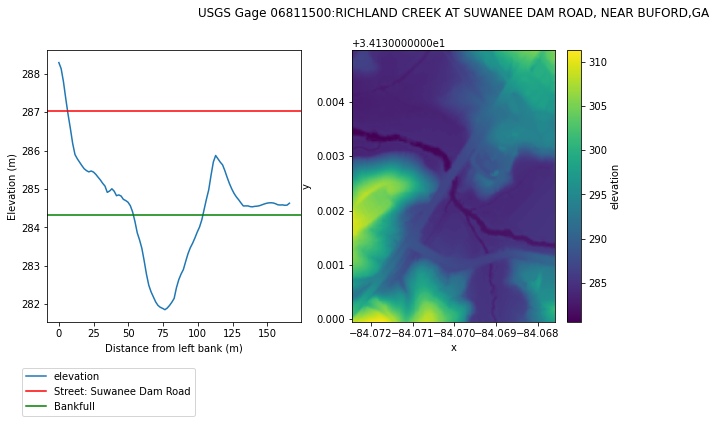

In [4]:
index = 0

m = plotGageLocation(index=index,
                       gage_location=gage_location,
                       gage_path=gage_path,
                       gage_thresholds=gage_thresholds,
                       cross_sections=cross_sections)

plotGageXS(index=index,
             gage_path=gage_path,
             gage_thresholds=gage_thresholds,
             cross_sections=cross_sections,
             gage_datum=gage_datum_m,
             dem = dem,
             dem_res=dem_res)
m

Available Resolution: res_3m:True, res_10m:True, res_30m:True


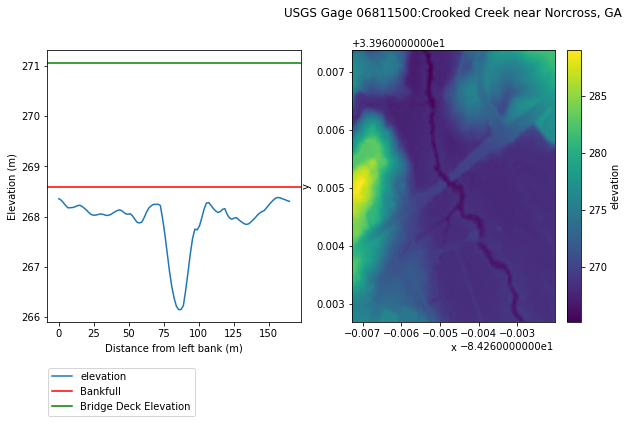

In [5]:
index = 1
m = plotGageLocation(index=index,
                       gage_location=gage_location,
                       gage_path=gage_path,
                       gage_thresholds=gage_thresholds,
                       cross_sections=cross_sections)

plotGageXS(index=index,
             gage_path=gage_path,
             gage_thresholds=gage_thresholds,
             cross_sections=cross_sections,
             gage_datum=gage_datum_m,
             dem = dem,
             dem_res=dem_res)
m

Available Resolution: res_10m:True, res_30m:True


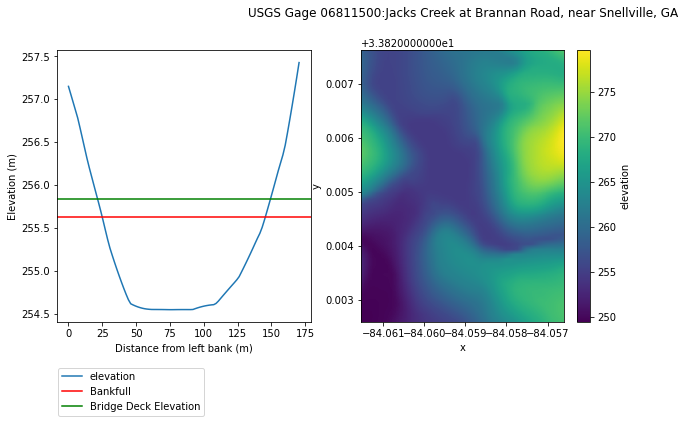

In [6]:
index = 2
m = plotGageLocation(index=index,
                       gage_location=gage_location,
                       gage_path=gage_path,
                       gage_thresholds=gage_thresholds,
                       cross_sections=cross_sections)

plotGageXS(index=index,
             gage_path=gage_path,
             gage_thresholds=gage_thresholds,
             cross_sections=cross_sections,
             gage_datum=gage_datum_m,
             dem = dem,
             dem_res=dem_res)
m

Available Resolution: res_1m:True, res_10m:True, res_30m:True


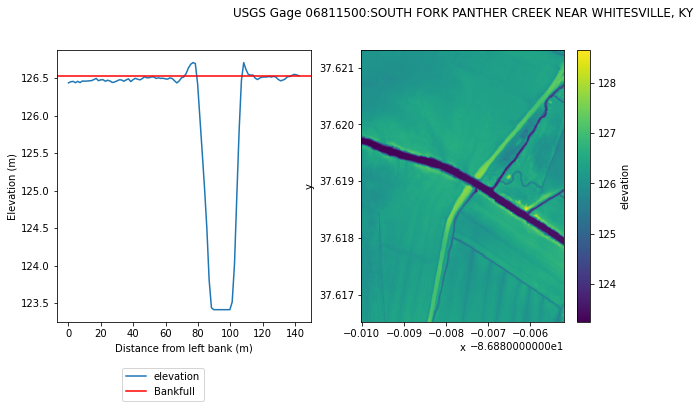

In [7]:
index = 3
m = plotGageLocation(index=index,
                       gage_location=gage_location,
                       gage_path=gage_path,
                       gage_thresholds=gage_thresholds,
                       cross_sections=cross_sections)

plotGageXS(index=index,
             gage_path=gage_path,
             gage_thresholds=gage_thresholds,
             cross_sections=cross_sections,
             gage_datum=gage_datum_m,
             dem = dem,
             dem_res=dem_res)
m

Available Resolution: res_1m:True, res_10m:True, res_30m:True


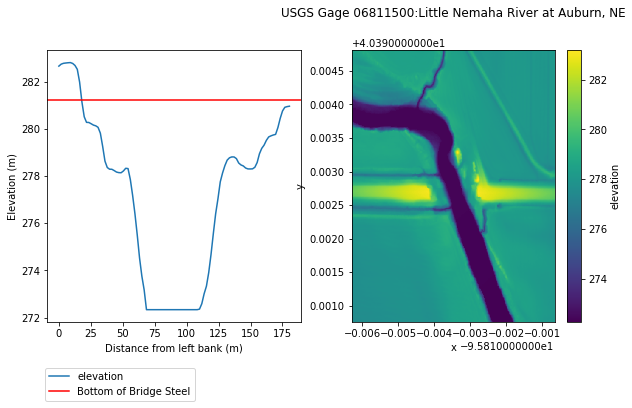

In [10]:
index = 4
m = plotGageLocation(index=index,
                       gage_location=gage_location,
                       gage_path=gage_path,
                       gage_thresholds=gage_thresholds,
                       cross_sections=cross_sections)

plotGageXS(index=index,
             gage_path=gage_path,
             gage_thresholds=gage_thresholds,
             cross_sections=cross_sections,
             gage_datum=gage_datum_m,
             dem = dem,
             dem_res=dem_res)
m

### Check measured thresholds against DEM interpolated values to provide context to the quality of the DEM interpolated cross-section

In [12]:
interpTValues(gage_path=gage_path,
              gage_thresholds=gage_thresholds,
              gage_datum_m=gage_datum_m,
              dem=dem)

Gage, Gage Name, Threshold Name, Threshold Value, DEM Interpolated Value, Difference
02334480,  RICHLAND CREEK AT SUWANEE DAM ROAD  NEAR BUFORD GA,  Street: Suwanee Dam Road,  287.039304,  286.82625577084383,  0.21304822915618615
02334480,  RICHLAND CREEK AT SUWANEE DAM ROAD  NEAR BUFORD GA,  Bankfull,  284.33268,  282.70211515938837,  1.630564840611612
02335350,  Crooked Creek near Norcross  GA,  Bankfull,  268.580616,  268.40536940552374,  0.17524659447627755
02335350,  Crooked Creek near Norcross  GA,  Bridge Deck Elevation,  271.067784,  269.09808053440264,  1.9697034655973766
02207055,  Jacks Creek at Brannan Road  near Snellville  GA,  Bankfull,  255.623568,  254.79304868703264,  0.8305193129673683
02207055,  Jacks Creek at Brannan Road  near Snellville  GA,  Bridge Deck Elevation,  255.839976,  254.56089016746822,  1.2790858325317913
03321350,  SOUTH FORK PANTHER CREEK NEAR WHITESVILLE  KY,  Bankfull,  126.534672,  126.47448790926339,  0.06018409073661246
06811500,  Little Nemah